In [1]:
import autograd.numpy as np
from autograd import grad

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import kde
from tqdm import tqdm_notebook
from scipy.optimize import minimize

In [4]:
x_class0 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([5, 5])
x_class1 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([5, -5])
x_class2 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([-5, -5])
x_class3 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([-5, 5])
y = np.squeeze(np.concatenate([np.zeros((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int)*2,
                               np.ones((1000,1), dtype=int)*3],
                              axis=0))
x = np.concatenate([x_class0, x_class1, x_class2, x_class3], axis=0)

In [5]:
def one_hot(arr):
    classes = np.unique(y)
    num_classes = len(classes)
    return classes,np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [6]:
classes,y_oh = one_hot(y)

In [7]:
classes

array([0, 1, 2, 3])

In [8]:
def softmax(z):
    z_clipped = z-z.max()
    log_softmax = z_clipped - np.log(np.sum(np.exp(z_clipped), axis=-1, keepdims=True))
    softmax_values = np.exp(log_softmax)
    return softmax_values

In [9]:
def compute_probabilities(X_matrix, theta):
    z = np.dot(X_matrix, theta)
    p = softmax(z)
    return p

In [10]:
def multinomial_cross_entropy(p_pred, y_true):
    return -np.sum(np.multiply(y_true, np.log(p_pred)), axis=-1, keepdims=True)

In [11]:
def multinomial_cross_entropy_loss(X, y, curr_theta):
    theta_matr = np.reshape(curr_theta, (X.shape[1]+1, 4))
    X_0 = np.ones((X.shape[0], 1), dtype=np.float64)
    X_matrix = np.concatenate([X_0, X], axis=1)    # N x f
    p = compute_probabilities(X_matrix, theta_matr) # N x K
    l = multinomial_cross_entropy(p, y)
    return np.squeeze(np.mean(l, axis=0, keepdims=True))

In [12]:
loss_fn = multinomial_cross_entropy_loss

In [13]:
grad_fn = grad(loss_fn, argnum=2)

In [14]:
theta_start = np.random.randn(x.shape[1]+1, 4).flatten()

In [15]:
curr_loss = loss_fn(x,y_oh,theta_start)
curr_loss

array(13.79532098)

In [16]:
curr_loss_grad = grad_fn(x,y_oh,theta_start)
curr_loss_grad

array([-0.2324759 ,  0.07357922,  0.17924703, -0.02035035, -1.16883727,
       -2.55783622,  1.09990386,  2.62676963, -1.2901366 , -0.33083049,
        3.67840598, -2.05743889])

In [17]:
loss_history = []
optimization_result = minimize(lambda t: float(loss_fn(x, y_oh, t)),
                               theta_start,
                               jac = lambda t: np.array(grad_fn(x, y_oh, t)).flatten(),
                               callback = lambda t: loss_history.append(float(loss_fn(x,y_oh,t))))

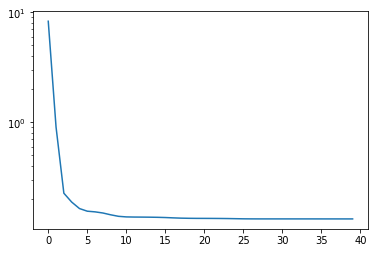

In [18]:
plt.plot(loss_history)
plt.yscale('log')

In [20]:
optimization_result

      fun: 0.1312986518447209
 hess_inv: array([[ 6.40824102e+01, -7.09538546e+01,  1.66775230e+01,
        -8.80607858e+00, -9.81407464e+00,  1.02569720e+01,
         3.10158796e+00, -3.54448528e+00, -7.35746903e+00,
        -5.58227088e+00,  9.38975630e+00,  3.54998361e+00],
       [-7.09538546e+01,  1.13015721e+02,  7.40532282e+00,
        -4.84671890e+01,  9.67533771e+00, -1.51318763e+01,
         5.63405653e+00, -1.77517942e-01,  1.51956441e+00,
         8.89101198e+00, -9.99844408e+00, -4.12132312e-01],
       [ 1.66775230e+01,  7.40532282e+00,  2.97222419e+01,
        -5.28050877e+01, -1.37449141e+00,  1.53143675e+00,
         6.13190040e+00, -6.28884573e+00, -5.27499063e+00,
        -2.71154149e+00,  2.52516628e-02,  7.96128046e+00],
       [-8.80607858e+00, -4.84671890e+01, -5.28050877e+01,
         1.11078355e+02,  1.51322834e+00,  3.34346759e+00,
        -1.48675449e+01,  1.00108490e+01,  1.11128953e+01,
        -5.97199616e-01,  5.83436121e-01, -1.10991318e+01],
       [-9.

In [19]:
theta_matr = np.reshape(optimization_result.x, (x.shape[1]+1, 4))

In [31]:
X_0 = np.ones((x.shape[0], 1), dtype=np.float64)
X_matrix = np.concatenate([X_0, x], axis=1)
pred_proba = compute_probabilities(X_matrix, theta_matr)

In [32]:
y_pred = classes[np.argmax(pred_proba, axis=1)]

In [33]:
np.mean(y_pred == y)

0.95225